## Teoretiska frågor

**1. Beskriv kort hur en relationsdatabas fungerar.**

En relationsdatabas består i huvudsak av tabeller med rader och kolumner där varje tabell representerar en viss typ av information som t.ex. ordrar, lager, fakturor. Mellan tabellerna skapas relationer vilket bl.a. gör det möjligt att få ut data ifrån flera tabeller vid en och samma sökning. 
Varje tabell har en primärnyckel där en kolumns data måste vara unik. Med hjälp av denna kan relationer skapas med andra tabeller och deras sk. främmande nycklar. Främmande nycklar är kolumner där informationen motsvarar och kan kopplas till en primärnyckel i en annan tabell och på så vis upprätta en relation dem emellan.


**2. Vad menas med “CRUD”-flödet?**

CRUD står för de grundläggande operationerna som finns för en relationsdatabas.
De står för:   
Create - skapar rader med information i tabeller   
Read - läsa ut data ifrån tabeller   
Update - uppdatera information som finns i tabeller   
Delete - ta bort rader ur tabeller    


**3. Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?**

Left join:
Vid sammanforgning av tabeller så innebär left join att man tar med alla de rader som finns i den först angivna tabellen (vänstra) men i den andra tabellen (högra) tas endast de rader med som har matchande värden i den vänstra. Om information inte finns i högra tabellen men finns i den vänstra så kommer raderna tas med men kolumner som är unika för den andra tabellen kommer innehålla NULL-värden.   
Inner Join: Vid sammanfogning av tabeller så innebär inner join att man får ut de rader som har matchande värden i de båda tabellerna. Om en rad endast finns i en utav tabellerna så tas den inte med.
Joins används för att sammanfoga tabeller och ger möjligheten att plocka ut data ur flera tabeller i samma sökning.


**4. Beskriv kort vad indexering i SQL innebär.**

Indexering är ett sätt att hitta rader med information snabbare utan att behöva gå igenom varje rad för rad i databasen. En kolumn kan sättas som index och söker man sedan på information som bör finnas i en sådan kolumn så finns den i en sorterad struktur som är mycket snabbare att hitta värden i.
Samtidigt som indexering innebär ett snabbare sätt att hitta data på så innebär det att uppdateringar av information blir långsammare eftersom index också måste uppdateras med varje förändring så det lämpar sig inte att ha indexering på all typ av information.


**5. Beskriv kort vad en vy i SQL är.**

En vy är ett sätt att spara undan en SQL-fråga så att man istället för att skriva en lång och komplicerad fråga varje gång man behöver den så finns den istället att anropa. Det kan också vara bra med en vy då användare inte bör ha tillgång till all information i tabellerna utan bara viss data.


**6. Beskriv kort vad en lagrad procedur i SQL är.**

En lagrad procedur är SQL-kod som sparats/skapats för att kunna tillkallas i en annan SQL-kod, som ett litet program som kan anropas då man skriver SQL-satser. Proceduren sparas i databasen och blir därför mycket snabbare att använda än att skriva ut alla de raderna på vanligt sätt i SQL koden. Liksom med vyer så kan man sätta behörigheter att använda en lagrad procedur och därmed inte behöva ge användaren behörigheter till all information i tabellerna.

## Programmeringsuppgift  
Ge en deskriptiv sammanfattning över databasen AdventureWorks2022. Syftet är att
läsaren skall få en god överblick över datan som finns. Använd några visualiseringar för att demonstrera intressanta aspekter av datan.

In [1]:
# Importera moduler
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import seaborn.objects as so
import pyodbc
from sqlalchemy.engine import create_engine, URL
from sqlalchemy import MetaData, Table, inspect, text
plot = False

In [2]:
# Databasanslutning
SERVER = 'localhost'
DATABASE = 'AdventureWorks2022'

connection_string = f"Driver={{ODBC Driver 18 for SQL Server}};Server={SERVER};Database={DATABASE};Trusted_Connection=yes;Encrypt=no"
connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})
engine = create_engine(connection_url)

### Beskriving av Databasen

Databasen Adventureworks2022 är en ralationsdatabas i SQL uppbyggd kring i huvudsak fem scheman: HumanResources, Person, Production, Purchasing och Sales.  
Den är strukturerad som en snowflake topologi och varje schema representerar olika delar i företaget Adventure Works Cycles verksamhet och innehåller allt ifrån 7 till 28 tabeller vardera.  

In [3]:
# Scheman och antalet tabeller
query = """
    SELECT 
        TABLE_SCHEMA AS Schemanamn, 
        COUNT(*) AS 'Antal tabeller'
    FROM 
        information_schema.tables
    WHERE 
        TABLE_SCHEMA NOT LIKE 'db%' -- Filtrera bort scheman som börjar med 'db'
    GROUP BY 
        TABLE_SCHEMA;
"""
schema_df = pd.read_sql(query, engine)
schema_df



,Schemanamn,Antal tabeller
0,Sales,26
1,Person,15
2,Production,28
3,HumanResources,12
4,Purchasing,7


Tabellerna har relationer till varandra genom nycklar och är normaliserade på ett icke-redundant sätt.

In [4]:
# Relationer mellan tabeller och dess nycklar (första 10)
# pd.options.display.max_rows = None -- ifall alla rader ska synas

query = """
SELECT TOP 10
    OBJECT_SCHEMA_NAME(fk.parent_object_id) AS referencing_fk_schema,   -- hämtar schemanamnet för tabellen med fk nyckeln
    OBJECT_NAME(fk.parent_object_id) AS referencing_fk_table,           -- hämtar namnet på tabellen med fk nyckeln 
    '>-',                                                               -- teckenstring för att visa riktning på relationen
    OBJECT_SCHEMA_NAME(fk.referenced_object_id) AS referenced_schema,   -- hämtar schemanamnet för tabellen som refereras till
    OBJECT_NAME(fk.referenced_object_id) AS referenced_table,           -- hämtar namnet på tabellen som refereras till
    COUNT(*) AS fk_column_count,                                        -- antalet kolumner i nyckelns relation
    fk.name AS fk_constraint_name                                       -- Namnet på främmande nyckelbegränsningen
FROM 
    sys.foreign_keys fk                                                 -- från systemvyn sys
GROUP BY
    OBJECT_SCHEMA_NAME(fk.parent_object_id),
    OBJECT_NAME(fk.parent_object_id),
    OBJECT_SCHEMA_NAME(fk.referenced_object_id),
    OBJECT_NAME(fk.referenced_object_id),
    fk.name
ORDER BY
    referencing_fk_schema, referencing_fk_table, fk_constraint_name;
"""
referencing_df = pd.read_sql(query, engine)
referencing_df

,referencing_fk_schema,referencing_fk_table,,referenced_schema,referenced_table,fk_column_count,fk_constraint_name
0,HumanResources,Employee,>-,Person,Person,1,FK_Employee_Person_BusinessEntityID
1,HumanResources,EmployeeDepartmentHistory,>-,HumanResources,Department,1,FK_EmployeeDepartmentHistory_Department_Depart...
2,HumanResources,EmployeeDepartmentHistory,>-,HumanResources,Employee,1,FK_EmployeeDepartmentHistory_Employee_Business...
3,HumanResources,EmployeeDepartmentHistory,>-,HumanResources,Shift,1,FK_EmployeeDepartmentHistory_Shift_ShiftID
4,HumanResources,EmployeePayHistory,>-,HumanResources,Employee,1,FK_EmployeePayHistory_Employee_BusinessEntityID
5,HumanResources,JobCandidate,>-,HumanResources,Employee,1,FK_JobCandidate_Employee_BusinessEntityID
6,Person,Address,>-,Person,StateProvince,1,FK_Address_StateProvince_StateProvinceID
7,Person,BusinessEntityAddress,>-,Person,Address,1,FK_BusinessEntityAddress_Address_AddressID
8,Person,BusinessEntityAddress,>-,Person,AddressType,1,FK_BusinessEntityAddress_AddressType_AddressTy...
9,Person,BusinessEntityAddress,>-,Person,BusinessEntity,1,FK_BusinessEntityAddress_BusinessEntity_Busine...


### Beskrivning av Adventure Works Cycles
Adventure Works Cycles tillverkar och säljer cyklar samt tillbehör i Nordamerika, Europa och Australien.     
De har 290 anställda och 19119 kunder i sin databas där merparten återfinns i USA. Deras produkter säljs i sammanlagt 701 butiker.   
   

För att få fram antal kunder så används tabellen Sales.Customer som innehåller 19820 CustomerID men både butiker och kunder har ett sådant ID däri så för att hitta rätt antal måste vi separera på kolumnerna PersonID och StoreID som omvartannat har NULL som värde beroende på vad som avses. Antal butiker kan fås både ur Sales.Store eller via StoreID som i ovan. Antalet anställda hittar vi i HumanResources.Employee och plockar med EndDate is NULL ifrån HumanResources.EmployeeDepartmentHistory.

In [5]:
# Antal kunder
query = """
    SELECT COUNT(*) AS 'Antal individuella kunder'
    FROM 
        Sales.Customer
    WHERE 
        PersonID IS NOT NULL;
"""
cust_df = pd.read_sql(query, engine)
cust_df

,Antal individuella kunder
0,19119


In [6]:
# Antal butiker
query = """
    SELECT COUNT(*) AS 'Antal butiker'
    FROM 
        Sales.Store
"""
stores_df = pd.read_sql(query, engine)
stores_df

,Antal butiker
0,701


In [7]:
# Antal Anställda
query = """
    SELECT COUNT(DISTINCT e.BusinessEntityID) AS 'Antal nuvarande anställda'
    FROM 
        HumanResources.Employee e
    INNER JOIN HumanResources.EmployeeDepartmentHistory edh ON e.BusinessEntityID = edh.BusinessEntityID
    WHERE 
        edh.EndDate IS NULL;
"""
employee_df = pd.read_sql(query, engine)
employee_df

,Antal nuvarande anställda
0,290


Vi vill kunna visa dessa värden i en gemensam tabell och dessutom fördelade per land och använder då oss av tre separata underfrågor i SQL som kombineras med UNION ALL för sammanställning.    
Det ser då ut som i tabellen och diagrammet nedan.



,Land,Antal anställda,Antal kunder,Antal butiker
0,United States,284,8210,427
1,Canada,2,1677,114
2,Australia,1,3625,40
3,France,1,1844,40
4,Germany,1,1812,40
5,United Kingdom,1,1951,40


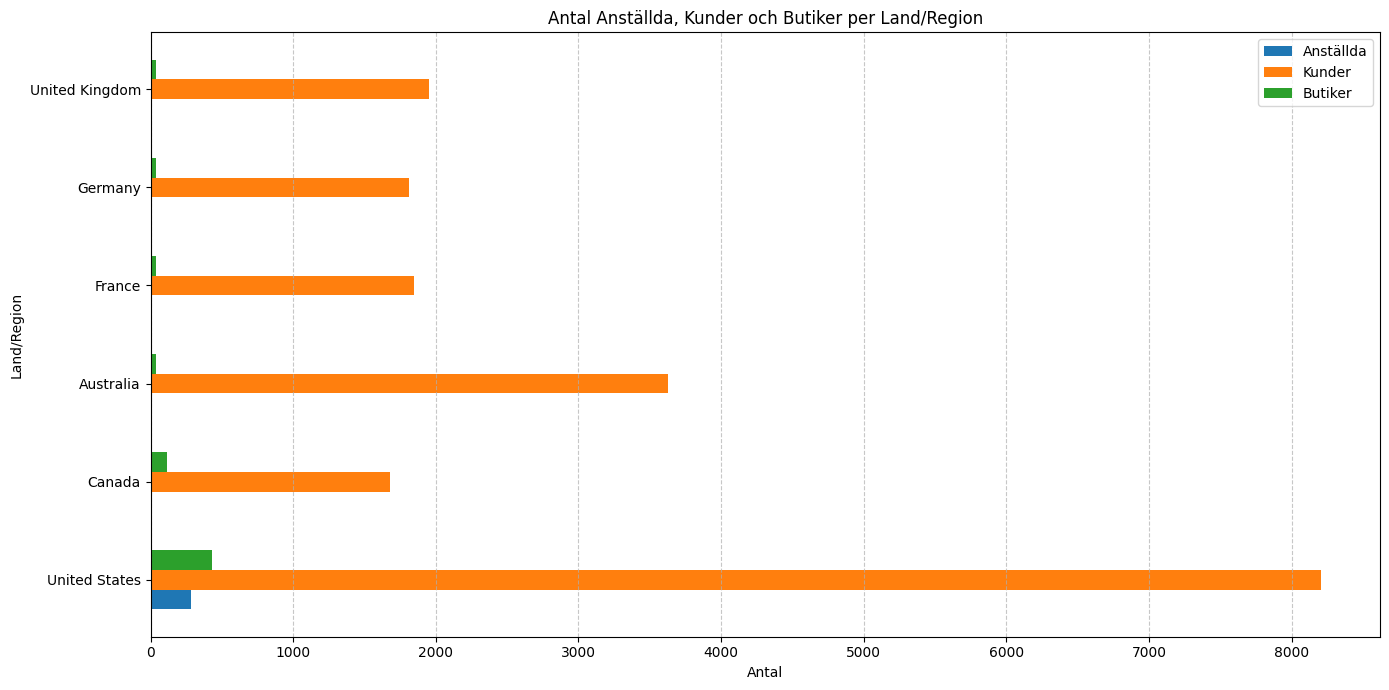

In [25]:
# Antal anställda, kunder och butiker per land
try:   # try-except-finally block för felhantering och uppstädning
    with engine.connect() as conn:
        query = """
            SELECT TOP 6
                Land,
                SUM(AntalAnstallda) AS 'Antal anställda',
                SUM(AntalKunder) AS 'Antal kunder',
                SUM(AntalButiker) AS 'Antal butiker'
            FROM (
                -- Underfråga för anställda
                SELECT
                    cr.Name AS Land,
                    COUNT(DISTINCT e.BusinessEntityID) AS AntalAnstallda,    
                    CAST(0 AS INT) AS AntalKunder,    -- lägger till en kolumn för AntalKunder och sätt som 0 för att kunna kombinera med UNION ALL
                    CAST(0 AS INT) AS AntalButiker    -- lägger till en kolumn för AntalButiker och sätt som 0 för att kunna kombinera med UNION ALL
                FROM Person.CountryRegion cr
                LEFT JOIN Person.StateProvince sp ON cr.CountryRegionCode = sp.CountryRegionCode
                LEFT JOIN Person.Address a ON sp.StateProvinceID = a.StateProvinceID
                LEFT JOIN Person.BusinessEntityAddress bea ON a.AddressID = bea.AddressID
                LEFT JOIN HumanResources.Employee e ON bea.BusinessEntityID = e.BusinessEntityID
                GROUP BY cr.Name

                UNION ALL    -- kombinerar resultatet med nästa SELECT-sats

                -- Underfråga för kunder
                SELECT
                    cr.Name AS Land,
                    CAST(0 AS INT) AS AntalAnstallda,    -- lägger till en kolumn för AntalAnställda och sätter som 0 för att kunna kombinera med UNION ALL
                    COUNT(DISTINCT c.PersonID) AS AntalKunder,
                    CAST(0 AS INT) AS AntalButiker    -- lägger till en kolumn för AntalButiker och sätter som 0 för att kunna kombinera med UNION ALL
                FROM Person.CountryRegion cr
                LEFT JOIN Sales.SalesTerritory st ON cr.CountryRegionCode = st.CountryRegionCode
                LEFT JOIN Sales.Customer c ON c.TerritoryID = st.TerritoryID
                GROUP BY cr.Name

                UNION ALL    -- kombinerar resultatet med nästa SELECT-sats

                -- Underfråga för butiker
                SELECT
                    cr.Name AS Land,
                    CAST(0 AS INT) AS AntalAnstallda,    -- lägger till en kolumn för AntalAnställda och sätt som 0 för att kunna kombinera med UNION ALL
                    CAST(0 AS INT) AS AntalKunder,    -- lägger till en kolumn för AntalKunder och sätt som 0 för att kunna kombinera med UNION ALL
                    COUNT(DISTINCT s.BusinessEntityID) AS AntalButiker
                FROM Person.CountryRegion cr
                LEFT JOIN Person.StateProvince sp ON cr.CountryRegionCode = sp.CountryRegionCode
                LEFT JOIN Person.Address a ON sp.StateProvinceID = a.StateProvinceID
                LEFT JOIN Person.BusinessEntityAddress bea ON a.AddressID = bea.AddressID
                LEFT JOIN Sales.Store s ON bea.BusinessEntityID = s.BusinessEntityID
                GROUP BY cr.Name
            ) AS CombinedResults 
            GROUP BY Land
            ORDER BY SUM(AntalAnstallda) DESC;
        """
        stat_df = pd.read_sql(text(query), conn)

        # NULL-värden i kolumnerna konverterars till heltal
        stat_df[['Antal anställda', 'Antal kunder', 'Antal butiker']] = stat_df[['Antal anställda', 'Antal kunder', 'Antal butiker']].fillna(0).astype(int)
        display(stat_df)
        
        # Konverterar kolumnerna till en numpy-array inför plottning
        countries = stat_df['Land'].to_numpy()     
        employees = stat_df['Antal anställda'].to_numpy()    
        customers = stat_df['Antal kunder'].to_numpy()    
        stores = stat_df['Antal butiker'].to_numpy()    

        y = np.arange(len(countries))    # Skapar en numpy-array för ländernas positioner
        width = 0.2

        plt.figure(figsize=(14, 7))
        plt.barh(y - width, employees, width, label='Anställda')    # horisontella staplar 
        plt.barh(y, customers, width, label='Kunder') 
        plt.barh(y + width, stores, width, label='Butiker') 

        plt.ylabel('Land/Region') 
        plt.xlabel('Antal') 
        plt.title('Antal Anställda, Kunder och Butiker per Land/Region')
        plt.yticks(y, countries)    # landens namn till y-axeln
        plt.legend()
        plt.grid(axis='x', linestyle='--', alpha=0.7) 
        plt.tight_layout()
        plt.show()


except sqlalchemy.exc.SQLAlchemyError as e:
    print(f"Ett databasfel inträffade: {e}")
except Exception as e:
    print(f"Ett annat fel inträffade: {e}")
finally:
    engine.dispose()

Adventure Works Cycle säljer 295 olika sorters produkter och dessa är fördelade i 4 huvudkategorier och 37 olika underkategorier.   

In [26]:
# Produktkategorier, subkategorier och antal produkter
try:   # try-except-finally block för felhantering och uppstädning
    with engine.connect() as conn:
        from IPython.display import display, HTML    # för visa tabeller bredvid varandra

        query = """
            SELECT pc.Name AS ProduktKatergori,
                    psc.Name AS ProduktSubKategori,
                    COUNT(*) AS AntalProdukter
            FROM 
                Production.Product p
            JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
            JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
            GROUP BY 
                pc.Name, psc.Name
            ORDER BY 
                pc.Name, AntalProdukter DESC;
        """
        prod_df = pd.read_sql(query, engine)
        total_products = prod_df['AntalProdukter'].sum()    # totalsumman av produkter
        total_subcategories = prod_df['ProduktSubKategori'].nunique() # antalet unika subkategorier

        # Sammanfattningstabell
        summary_data = {'Metric': ['Totalt antal Produkter', 'Totalt antal Subkategorier'],
                        'Value': [total_products, total_subcategories]}
        summary_df = pd.DataFrame(summary_data)

        styled_df = prod_df.style 
        styled_summary_df = summary_df.style

        display(HTML(styled_df.to_html(index=False) + styled_summary_df.to_html(index=False)))    # Visa tabellerna bredvid varandra

except sqlalchemy.exc.SQLAlchemyError as e:
    print(f"Ett databasfel inträffade: {e}")
except Exception as e:
    print(f"Ett annat fel inträffade: {e}")
finally:
    engine.dispose()


,ProduktKatergori,ProduktSubKategori,AntalProdukter
0,Accessories,Tires and Tubes,11
1,Accessories,Helmets,3
2,Accessories,Bottles and Cages,3
3,Accessories,Lights,3
4,Accessories,Pumps,2
5,Accessories,Hydration Packs,1
6,Accessories,Panniers,1
7,Accessories,Locks,1
8,Accessories,Fenders,1
9,Accessories,Bike Racks,1


Tabellen nedan visar försäljningen fördelat per land både för totalen och för de olika kategorierna av produkter.

In [11]:
# Försäljning per land
from IPython.display import HTML
try:
    with engine.connect() as conn:
        query = """
            SELECT
                st.CountryRegionCode AS Land,
                pc.Name AS Kategori,
                SUM(sod.LineTotal) AS TotalFörsäljning
            FROM 
                Sales.SalesOrderDetail sod
            JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
            JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
            JOIN Production.Product p ON sod.ProductID = p.ProductID
            JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
            JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
            GROUP BY
                st.CountryRegionCode, pc.Name
            ORDER BY
                st.CountryRegionCode, pc.Name;
        """
        sales_df = pd.read_sql(text(query), conn)

        total_försäljning_alla = sales_df['TotalFörsäljning'].sum()    # räknar ut totala försäljningen
        pivot_df = sales_df.pivot_table(index='Kategori', columns='Land', values='TotalFörsäljning', aggfunc='sum', fill_value=0)    # försäljning per kategori och land
        pivot_percent_df = (pivot_df / total_försäljning_alla) * 100   
        pivot_percent_df['Total'] = pivot_percent_df.sum(axis=1)   
        total_row = pivot_percent_df.sum(axis=0)
        total_row.name = 'Total' 
        pivot_percent_df = pd.concat([pivot_percent_df, pd.DataFrame(total_row).T])
        pivot_percent_df = pivot_percent_df.map('{:.1f}%'.format).fillna("0.0%") # Gör om till procent med en decimal samt hantera NaN-värden
        
        html_table = pivot_percent_df.to_html(index=True)   #konvertera till HTML för tabellen
        display(HTML(html_table))
             
except sqlalchemy.exc.SQLAlchemyError as e:
    print(f"Ett databasfel inträffade: {e}")
except Exception as e:
    print(f"Ett annat fel inträffade: {e}")
finally:
    engine.dispose()

Land,AU,CA,DE,FR,GB,US,Total
Accessories,0.1%,0.2%,0.1%,0.1%,0.1%,0.5%,1.2%
Bikes,9.3%,12.3%,4.0%,5.6%,6.1%,49.0%,86.2%
Clothing,0.1%,0.4%,0.1%,0.1%,0.1%,1.1%,1.9%
Components,0.2%,2.0%,0.3%,0.8%,0.6%,6.8%,10.7%
Total,9.7%,14.9%,4.5%,6.6%,7.0%,57.4%,100.0%


Omsättningen liksom vinstmarginalen har ökat över tid sedan 2011 och det finns en bra uppåtgående trend men samtidigt en stor variation mellan februari-mars-april 2014 vad gäller omsättningen.   
Detta syns i diagrammet nedan och blir extra tydligt i barplot-diagrammet på år 2014 som vi analyserar lite ytterligare sedan.   
Det går också att se en ökning i omsättning under sommaren 2013 som vi senare kommer se troligen beror på att onlineförsäljningen gick upp väldigt mycket.   
Vinstmarginalen var ovanligt låg i april-maj 2012 men återhämtar sig bra därefter, framför allt efter sommaren 2013 då onlineförsäljningen skjuter i höjden.

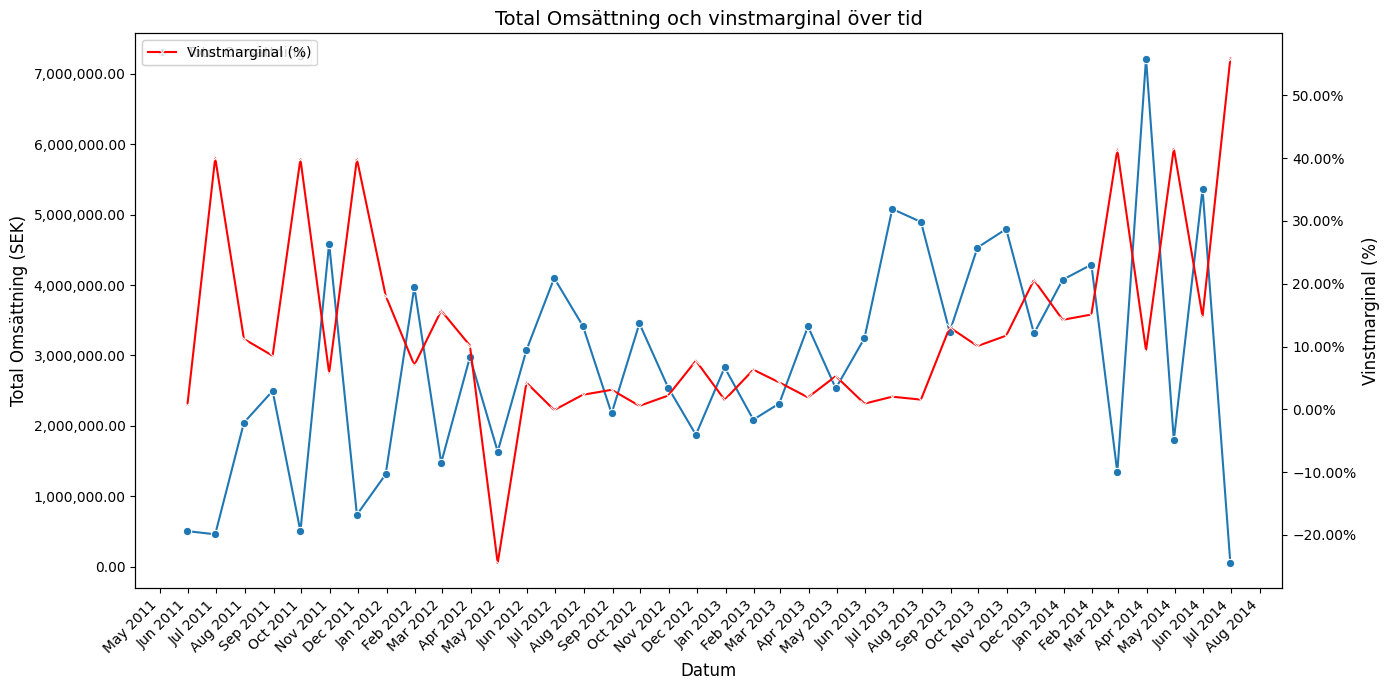

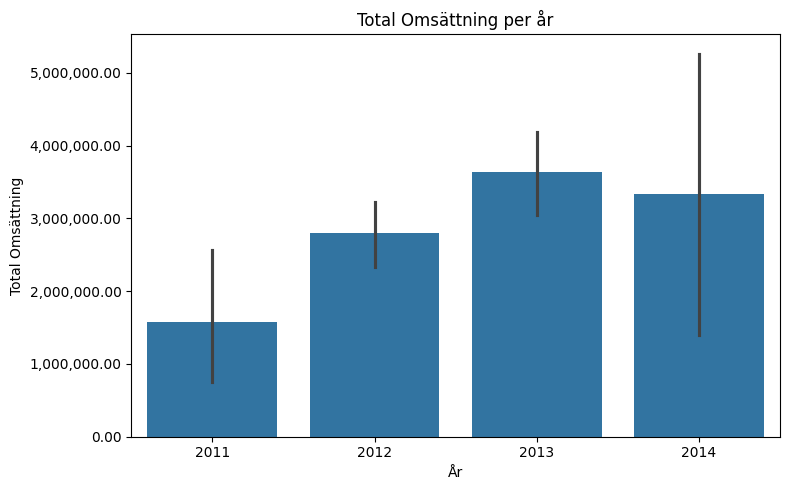

In [12]:
# Omsättning och vinstmarginal per månad
try:
    with engine.connect() as conn:
        query = """
            SELECT
                EOMONTH(soh.OrderDate) AS SalesDate,
                SUM(sod.LineTotal) AS TotalRevenue,
                SUM(p.StandardCost * sod.OrderQty) AS TotalCost,
                CASE    -- undvika division med 0
                    WHEN SUM(sod.LineTotal) = 0 THEN 0.0    
                    ELSE (SUM(sod.LineTotal) - SUM(p.StandardCost * sod.OrderQty)) * 100.0 / SUM(sod.LineTotal)
                END AS GrossProfitMargin
            FROM 
                Sales.SalesOrderHeader soh
            JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
            JOIN Production.Product p ON sod.ProductID = p.ProductID
            GROUP BY
                EOMONTH(soh.OrderDate)
            ORDER BY
                SalesDate;
        """
        oms_df = pd.read_sql(query, engine)

        oms_df['SalesDate'] = pd.to_datetime(oms_df['SalesDate'])    # konvertera till datetime 

        fig, ax1 = plt.subplots(figsize=(14, 7))

        # linjediagram
        sns.lineplot(x='SalesDate', y='TotalRevenue', data=oms_df, label='Total Omsättning', marker='o', ax=ax1)
        ax1.set_xlabel('Datum', fontsize=12)
        ax1.set_ylabel('Total Omsättning (SEK)', fontsize=12)
        ax1.tick_params(axis='y')
        ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}')) 

        # Subplot i samma diagram
        ax2 = ax1.twinx()
        sns.lineplot(x='SalesDate', y='GrossProfitMargin', data=oms_df, label='Vinstmarginal (%)', marker='x', color='red', ax=ax2)
        ax2.set_ylabel('Vinstmarginal (%)', fontsize=12)
        ax2.tick_params(axis='y')
        ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}%')) 

        # Månaderna på x-axeln
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        plt.title('Total Omsättning och vinstmarginal över tid', fontsize=14)

        fig.tight_layout()
        plt.show()

        # Barplot omsättning per år
        oms_df['SalesYear'] = oms_df['SalesDate'].dt.year
        plt.figure(figsize=(8, 5))
        sns.barplot(x='SalesYear', y='TotalRevenue', data=oms_df)
        plt.title('Total Omsättning per år')
        plt.xlabel('År')
        plt.ylabel('Total Omsättning')
        plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}')) 
        plt.tight_layout()
        plt.show()

except sqlalchemy.exc.SQLAlchemyError as e:
    print(f"Ett databasfel inträffade: {e}")
except Exception as e:
    print(f"Ett annat fel inträffade: {e}")
finally:
    engine.dispose()


Bäst säljande produkt i antal är en AWC Logo keps följt av en vattenflaska medan produkter som säljer sämst i antal är ramar till specifika cykelmodeller.   
     


In [13]:
# 10 bäst och sämst säljande produkterna med kategorier, omsättning och antal:
query = """
    SELECT TOP 10 
        p.Name AS Produktnamn, 
        pc.Name AS Katergori, 
        SUM(sod.LineTotal) AS 'Total omsättning', 
        SUM(sod.OrderQty) AS 'Antal sålda'
    FROM 
        Sales.SalesOrderDetail sod
    JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
    JOIN Production.Product p ON sod.ProductID = p.ProductID
    JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
    JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
    GROUP BY 
        p.Name, pc.Name
    ORDER BY 
        'Antal sålda' DESC
"""
mostsold = pd.read_sql(query, engine)
display(mostsold.style.format({col: "{:.0f}".format for col in mostsold.select_dtypes(include=np.number)})) 

query = """
    SELECT TOP 10 
        p.Name AS Produktnamn, 
        pc.Name AS Kategori, 
        SUM(sod.LineTotal) AS 'Total omsättning', 
        SUM(sod.OrderQty) AS 'Antal sålda'
    FROM 
        Sales.SalesOrderDetail sod
    JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
    JOIN Production.Product p ON sod.ProductID = p.ProductID
    JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
    JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
    GROUP BY 
        p.Name, pc.Name
    ORDER BY 
        'Antal sålda' ASC
"""

leastsold = pd.read_sql(query, engine)
display(leastsold.style.format({col: "{:.0f}".format for col in leastsold.select_dtypes(include=np.number)})) 



,Produktnamn,Katergori,Total omsättning,Antal sålda
0,AWC Logo Cap,Clothing,51229,8311
1,Water Bottle - 30 oz.,Accessories,28654,6815
2,"Sport-100 Helmet, Blue",Accessories,165407,6743
3,"Long-Sleeve Logo Jersey, L",Clothing,198755,6592
4,"Sport-100 Helmet, Black",Accessories,160870,6532
5,"Sport-100 Helmet, Red",Accessories,157772,6266
6,"Classic Vest, S",Clothing,156398,4247
7,Patch Kit/8 Patches,Accessories,8233,3865
8,"Short-Sleeve Classic Jersey, XL",Clothing,129146,3864
9,"Long-Sleeve Logo Jersey, M",Clothing,115249,3636


,Produktnamn,Kategori,Total omsättning,Antal sålda
0,"LL Touring Frame - Blue, 58",Components,800,4
1,"ML Mountain Frame-W - Silver, 38",Components,1529,7
2,"LL Mountain Frame - Black, 40",Components,1199,8
3,LL Road Seat/Saddle,Components,163,10
4,"LL Touring Frame - Blue, 62",Components,3001,15
5,"LL Mountain Frame - Black, 52",Components,2248,15
6,"HL Mountain Frame - Black, 44",Components,13766,17
7,"LL Touring Frame - Blue, 44",Components,5001,25
8,"LL Touring Frame - Yellow, 58",Components,7202,36
9,"LL Mountain Frame - Silver, 48",Components,6971,44


Bland produkterna med högst vinstmarginal (över 60% marginal) hittar vi olika varianter av cykeldäck, en variant av skärm och cykelstöd.  
De produkter som har sämst vinstmarginal, förlust rentav, är Logo-tröjor samt ett antal cykelmodeller och det kikar vi mera på i analysen sedan.   


In [14]:
# Produkterna med största vinstmarginalen (topp 10)
query = """
    SELECT TOP 10
        p.Name AS Produktnamn,
        SUM(sod.OrderQty * sod.UnitPrice) AS 'Total omsättning',
        SUM(sod.OrderQty * p.StandardCost) AS 'Total inköpskostnad',
        SUM(sod.OrderQty * sod.UnitPrice) - SUM(sod.OrderQty * p.StandardCost) AS 'Total vinst',
        ((SUM(sod.OrderQty * sod.UnitPrice) - SUM(sod.OrderQty * p.StandardCost)) * 100.0 / SUM(sod.OrderQty * sod.UnitPrice)) AS 'Vinstmarginal %'
    FROM
        Sales.SalesOrderDetail sod
    JOIN
        Production.Product p ON sod.ProductID = p.ProductID
    GROUP BY
        p.Name
    ORDER BY
        'Vinstmarginal %' DESC;
"""
mestmarg = pd.read_sql(query, engine)
display(mestmarg.style.format({col: "{:.0f}".format for col in mestmarg.select_dtypes(include=np.number)}))


,Produktnamn,Total omsättning,Total inköpskostnad,Total vinst,Vinstmarginal %
0,Fender Set - Mountain,46620,17436,29184,63
1,HL Mountain Tire,48860,18274,30586,63
2,All-Purpose Bike Stand,39591,14807,24784,63
3,HL Road Tire,27971,10461,17510,63
4,ML Mountain Tire,34818,13022,21796,63
5,Touring Tire,27106,10138,16968,63
6,LL Mountain Tire,21541,8057,13485,63
7,ML Road Tire,23141,8655,14486,63
8,LL Road Tire,22436,8391,14045,63
9,Mountain Bottle Cage,20230,7566,12664,63


### Statistisk analys
Vi undersöker här det genomsnittliga ordervärdet, räknar ut standardavvikelsen och anger ett konfidensintervall med hjälp av t-fördelning (antalet frihetsgrader = antal observationer -1).   
Antal observationer vi använder är de 31 465 ordrar som finns i databasen.   
   
Med 95% sannolikhet ligger det sanna genomsnittliga ordervärdet mellan 3777.71 och 4054.29 och skulle vi vilja ha en högre sannolikhet på 99% så hamnar intervallet istället på mellan 3734.25 och 4097.74, alltså lite bredare.   
   
Det finns en snedfördelning med en mycket lång svans åt höger eftersom ett mindre antal ordrar har riktigt höga ordervärden, upp emot 187 000 och detta förklarar den höga standardavvikelsen på ~12515.   
I det andra histogrammet nedan ser vi att de flesta ordrar annars sällan har ett ordervärde över 5000.   
I box-plot diagrammet kan man se spridningen och att det blir glesare med ordervärden ju högre upp på skalan värdet är.
   
Medianen på ~ 865 och percentilerna i tabellen visar också på vilket sned spridning det är när 90% av ordrarna har ett värde på ~3953 eller lägre samtidigt som det ligger mycket nära medelvärdet.


Genomsnittligt ordervärde: 3916.00
Standardavvikelse för ordervärden: 12515.26
Antal ordrar: 31465
95% Konfidensintervall: (3777.70, 4054.29)
99% Konfidensintervall: (3734.24, 4097.75)

median:     865.20
count     31465.000000
mean       3915.995109
std       12515.462713
min           1.518300
25%          62.951900
50%         865.204000
75%        2615.490800
90%        3953.988400
95%       20430.546040
99%       69303.264232
max      187487.825000
Name: TotalDue, dtype: float64


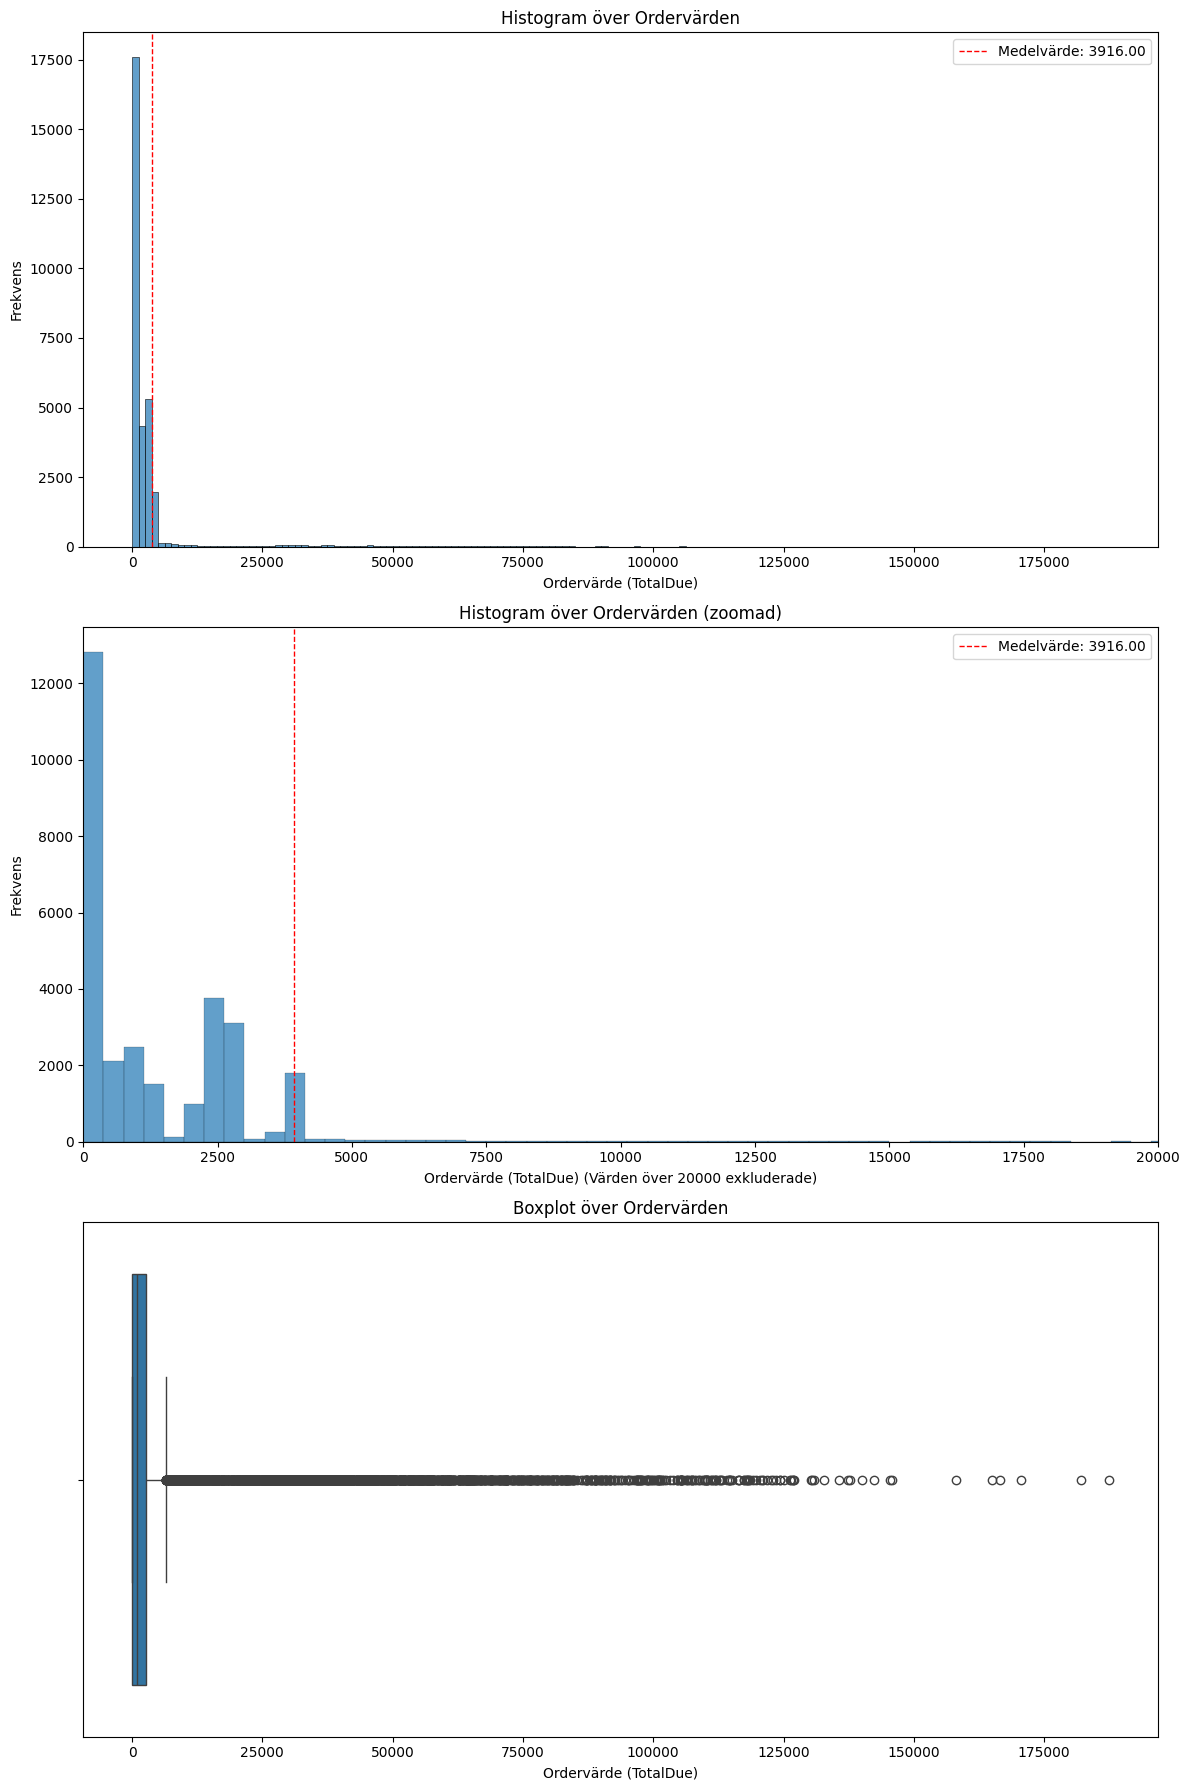

In [16]:
# Genomsnittligt ordervärde, standardavvikelse och konfidensintervall

def calculate_confidence_interval(data, confidence=0.95):
    """Beräknar konfidensintervallet med t-fördelning."""
    n = len(data)    # antalet omservationer
    if n < 2:  
        return None
    mean = np.mean(data)    # medelvärdet
    std_err = st.sem(data)    # standardfelet
    if np.isnan(std_err) or std_err == 0:    # kontrollera division med 0
        return None
    h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)   # t-värdet
    return mean - h, mean + h    # undre och övre gränsen för konfidensintervallet

try:
    with engine.connect() as conn:
        query = """
            SELECT TotalDue 
            FROM Sales.SalesOrderHeader;
        """
        df = pd.read_sql(query, conn) 
      
        order_values = df['TotalDue'].values    # konverterar till NumPy

        # Deskriptiv statistik
        average_order_value = np.mean(order_values)
        std_dev = np.std(order_values)
        num_orders = len(order_values)

        confidence_interval_95 = calculate_confidence_interval(order_values) 
        confidence_interval_99 = calculate_confidence_interval(order_values, confidence=0.99) 

        lower_95, upper_95 = confidence_interval_95
        lower_99, upper_99 = confidence_interval_99
        print(f"Genomsnittligt ordervärde: {average_order_value:.2f}")
        print(f"Standardavvikelse för ordervärden: {std_dev:.2f}")
        print(f"Antal ordrar: {num_orders}")
        print(f"95% Konfidensintervall: ({lower_95:.2f}, {upper_95:.2f})")
        print(f"99% Konfidensintervall: ({lower_99:.2f}, {upper_99:.2f})")

        print()

        beskrivande_statistik = df['TotalDue'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]) 
        median_ordervarde = df['TotalDue'].median() 
        print(f"median:     {median_ordervarde:.2f}") 
        print(beskrivande_statistik)

        fig, axes = plt.subplots(3, 1, figsize=(12, 18)) 

        sns.histplot(order_values, bins=150, edgecolor='black', alpha=0.7, ax=axes[0])
        axes[0].set_xlabel('Ordervärde (TotalDue)')
        axes[0].set_ylabel('Frekvens')
        axes[0].set_title('Histogram över Ordervärden')
        axes[0].axvline(average_order_value, color='red', linestyle='dashed', linewidth=1, label=f'Medelvärde: {average_order_value:.2f}')
        axes[0].legend()

        sns.histplot(order_values, bins=500, edgecolor='black', alpha=0.7, ax=axes[1])
        axes[1].set_xlim(0, 20000)
        axes[1].set_xlabel('Ordervärde (TotalDue) (Värden över 20000 exkluderade)')
        axes[1].set_ylabel('Frekvens')
        axes[1].set_title('Histogram över Ordervärden (zoomad)')
        axes[1].axvline(average_order_value, color='red', linestyle='dashed', linewidth=1, label=f'Medelvärde: {average_order_value:.2f}')
        axes[1].legend()

        sns.boxplot(x=order_values, ax=axes[2]) 
        axes[2].set_xlabel('Ordervärde (TotalDue)')
        axes[2].set_title('Boxplot över Ordervärden')

        plt.tight_layout()
        plt.show()

except sqlalchemy.exc.SQLAlchemyError as e:
    print(f"Ett databasfel inträffade: {e}")
except Exception as e:
    print(f"Ett oväntat fel inträffade: {e}")
finally:
    engine.dispose()

### Analys av data med slutsatser och rekommendationer
Som vi såg förut så har Adventure Works Cycles en ovanligt stor variation av omsättningen mellan februari-mars-april 2014.   
När vi tittar närmare på detta så ser det ut som man sålt färre än vanligt av produkterna i februari och april medan mars fått ett större antal produkter sålda än vanligt.   
Förändringarna verkar inte vara kopplad till en viss typ av produkt eller kategori utan ser ut att vara genomgående över sortimentet.   
Nedan visas skillnaden i försäljning av ett antal produkter under februari, mars och april.

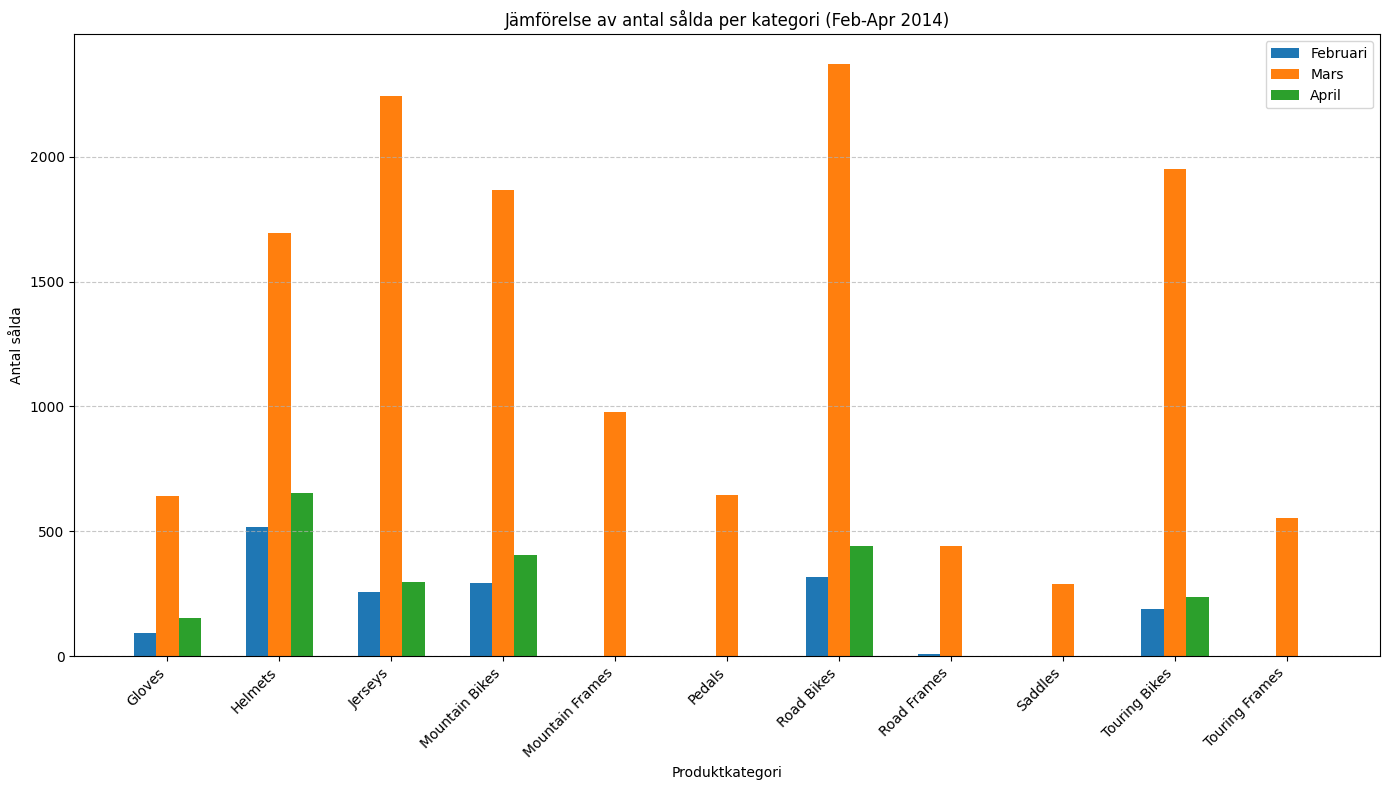

In [27]:
# Variation i omsättningen februari, mars och april 2014.
try:
    with engine.connect() as conn:
        query = """
            SELECT
                YEAR(soh.OrderDate) AS Försäljningsår,
                MONTH(soh.OrderDate) AS Försäljningsmånad,
                psc.Name AS Produktkategori,
                SUM(sod.OrderQty) AS 'Antal sålda'
            FROM
                Sales.SalesOrderHeader soh
            JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
            JOIN Production.Product p ON sod.ProductID = p.ProductID
            JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
            WHERE YEAR(soh.OrderDate) = 2014 AND MONTH(soh.OrderDate) IN (2, 3, 4)
              AND psc.Name IN ('Touring Bikes', 'Road Bikes', 'Mountain Bikes', 'Mountain Frames', 'Touring Frames', 'Road Frames', 'Jerseys', 'Helmets', 'Pedals', 'Saddles', 'Gloves')
            GROUP BY
                YEAR(soh.OrderDate), MONTH(soh.OrderDate), psc.Name
            ORDER BY Försäljningsmånad, Produktkategori;
        """

        omsvar_df = pd.read_sql(text(query), conn)
        # display(omsvar_df)    # tabell över värdena

        pivot_df = omsvar_df.pivot_table(index='Produktkategori', columns='Försäljningsmånad', values='Antal sålda', fill_value=0)
        months = {2: 'Februari', 3: 'Mars', 4: 'April'}
        pivot_df = pivot_df.rename(columns=months)
        categories = pivot_df.index
        bar_width = 0.2
        x = np.arange(len(categories))
        fig, ax = plt.subplots(figsize=(14, 8))

        for i, month in enumerate(pivot_df.columns):
            quantities = pivot_df[month].to_numpy()
            ax.bar(x + (i-1)*bar_width, quantities, bar_width, label=month)

        ax.set_xticks(x)
        ax.set_xticklabels(categories, rotation=45, ha='right')
        ax.set_ylabel('Antal sålda')
        ax.set_xlabel('Produktkategori')
        ax.set_title('Jämförelse av antal sålda per kategori (Feb-Apr 2014)')
        ax.legend()
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

except sqlalchemy.exc.SQLAlchemyError as e:
    print(f"Ett databasfel inträffade: {e}")
except Exception as e:
    print(f"Ett annat fel inträffade: {e}")
finally:
    engine.dispose()

Det verkar inte som om det heller funnits kampanjer eller rabatter i tillräckligt stor utsträckning under mars för att ha kunnat boosta försäljningen och utgöra en sådan skillnad. Det såldes 91 rabatterade artiklar under mars månad med liten genomsnittlig rabatt så ökningarna beror troligen inte på en kampanj.

In [18]:
# Kampanjer eller rabatter under mars
query = """
    SELECT
        YEAR(soh.OrderDate) AS Försäljningsår,
        MONTH(soh.OrderDate) AS Försäljningsmånad,
        AVG(sod.UnitPriceDiscount) *100 AS 'Rabatt genomsnitt'
    FROM
        Sales.SalesOrderHeader soh
    JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
    WHERE 
        YEAR(soh.OrderDate) = 2014 AND MONTH(soh.OrderDate) IN (2, 3, 4)
    GROUP BY
        YEAR(soh.OrderDate), MONTH(soh.OrderDate)
    ORDER BY
        Försäljningsår, Försäljningsmånad;
"""
kamp_df = pd.read_sql(query, engine)
kamp_df

,Försäljningsår,Försäljningsmånad,Rabatt genomsnitt
0,2014,2,0.00
1,2014,3,0.43
2,2014,4,0.00


In [19]:
# Ordrar med rabatter
query = """
    SELECT
        YEAR(soh.OrderDate) AS Försäljningsår,
        MONTH(soh.OrderDate) AS Försäljningsmånad,
        COUNT(DISTINCT soh.SalesOrderID) AS 'Rabatterade ordrar'
    FROM
        Sales.SalesOrderHeader soh
    JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
    WHERE 
        YEAR(soh.OrderDate) = 2014 AND MONTH(soh.OrderDate) IN (2, 3, 4) AND sod.UnitPriceDiscount > 0
    GROUP BY
        YEAR(soh.OrderDate), MONTH(soh.OrderDate)
    ORDER BY
        Försäljningsår, Försäljningsmånad;
"""
discount_df = pd.read_sql(query, engine)
discount_df

,Försäljningsår,Försäljningsmånad,Rabatterade ordrar
0,2014,3,91


Onlineförsäljningen borde vid tillfället stå för en stor del av försäljningen och då borde det synas en liknande variation som i totala omsättningen. 
En viss ökning syns i antal ordrar mellan februari och mars men antalet ordrar går inte ner i tillräcklig utsträckning i april sedan.   
Det som däremot syns i diagrammet nedan är en rejäl ökning av onlineförsäljningen i maj-juni 2013 men vi går inte in på detta närmare här mer än att vi såg förut att det också resulterade i en ökad omsättning efter sommaren 2013. Det kan vara så att detta var startskottet för en ny startegi, kampanj eller handelsplattform vad gäller onlineförsäljning runt tidpunkten.

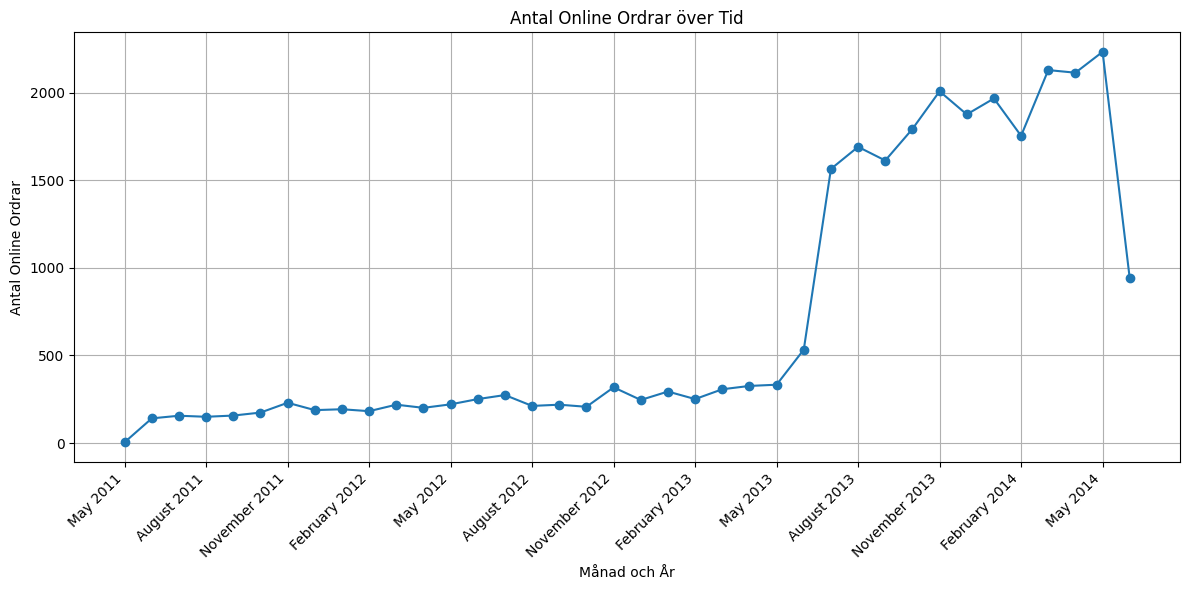

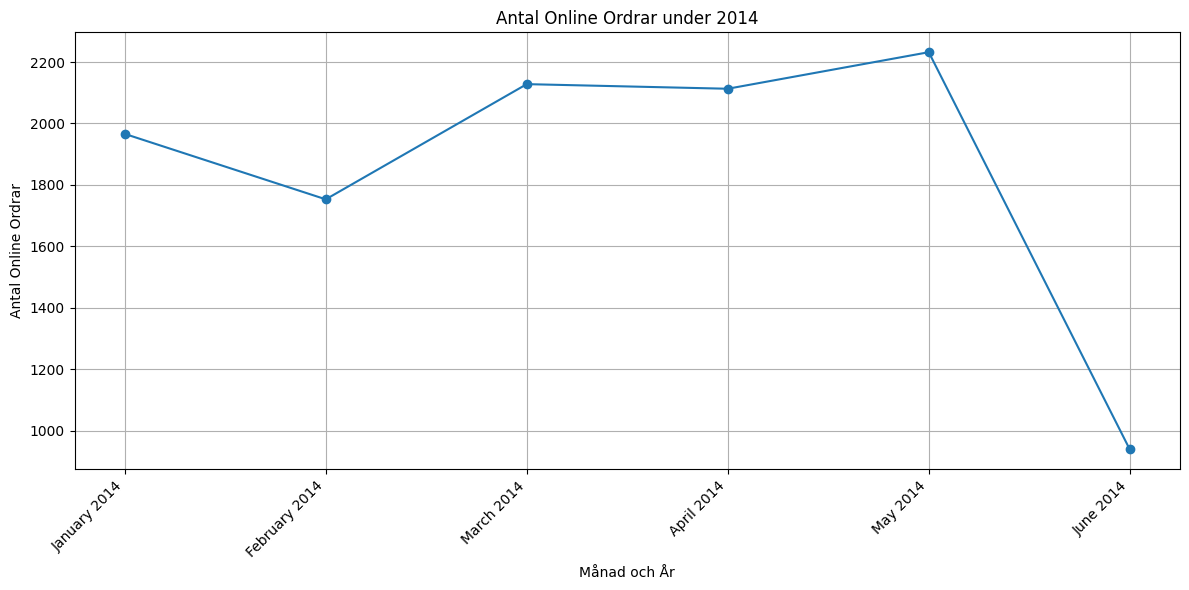

In [20]:
# Onlineordrar
import calendar
try:
    with engine.connect() as conn:
        query = """
            SELECT
                YEAR(OrderDate) AS År,
                MONTH(OrderDate) AS Månad,
                COUNT(*) AS AntalOnlineOrdrar
            FROM 
                Sales.SalesOrderHeader
            WHERE 
                OnlineOrderFlag = 1
            GROUP BY 
                YEAR(OrderDate), MONTH(OrderDate)
            ORDER BY 
                YEAR(OrderDate), MONTH(OrderDate);
        """
        online_df = pd.read_sql(text(query), conn)

        online_df['Månad_År'] = online_df.apply(lambda row: f"{calendar.month_name[row['Månad']]} {row['År']}", axis=1)    # skapar ny kolumn på varje rad

        plt.figure(figsize=(12, 6))
        plt.plot(online_df['Månad_År'], online_df['AntalOnlineOrdrar'], marker='o', linestyle='-') 
        plt.xlabel('Månad och År')
        plt.ylabel('Antal Online Ordrar')
        plt.title('Antal Online Ordrar över Tid')
        plt.xticks(online_df['Månad_År'][::3], rotation=45, ha='right') 
        plt.grid(True) 
        plt.tight_layout()
        
        online_2014_df = online_df[online_df['År'] == 2014]
        
        plt.figure(figsize=(12, 6)) 
        plt.plot(online_2014_df['Månad_År'], online_2014_df['AntalOnlineOrdrar'], marker='o', linestyle='-')
        plt.xlabel('Månad och År')
        plt.ylabel('Antal Online Ordrar')
        plt.title('Antal Online Ordrar under 2014') 
        plt.xticks(online_2014_df['Månad_År'], rotation=45, ha='right') 
        plt.grid(True)
        plt.tight_layout()
        
        plt.show()

except sqlalchemy.exc.SQLAlchemyError as e:
    print(f"Ett databasfel inträffade: {e}")
except Exception as e:
    print(f"Ett annat fel inträffade: {e}")
finally:
    engine.dispose()

Vi ser också nedan att det inte är något enskilt försäljningsområde som står för ökningen.   
Områdena Southwest och Northwest i USA samt Australien och Canada säljer generellt mer än de andra ormådena men i mars har samtliga områden ökat.   


   

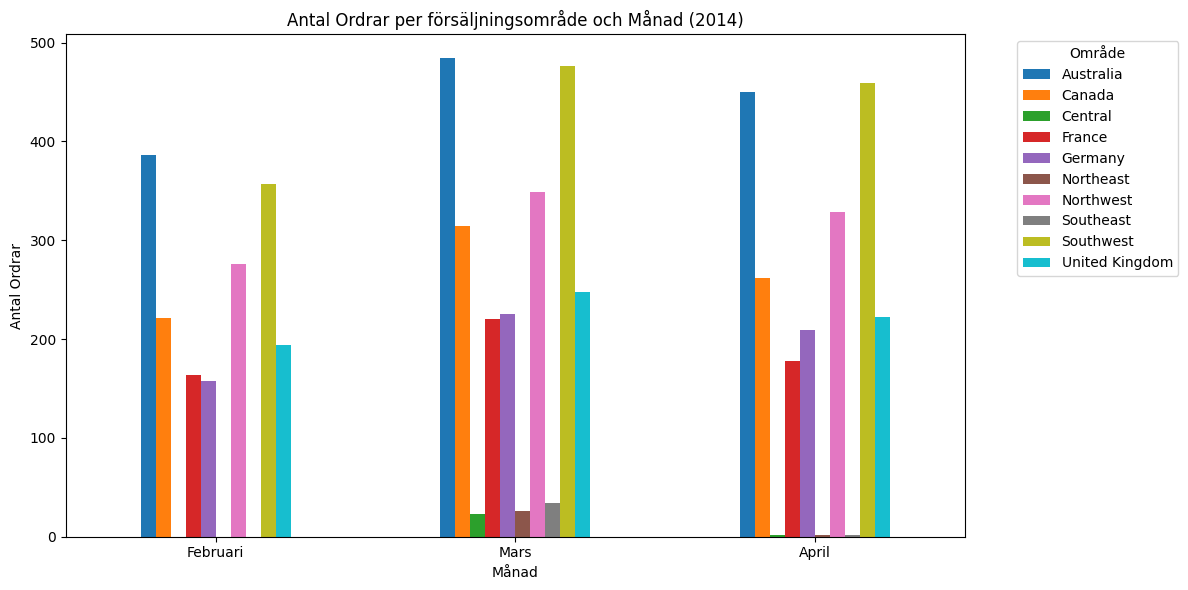

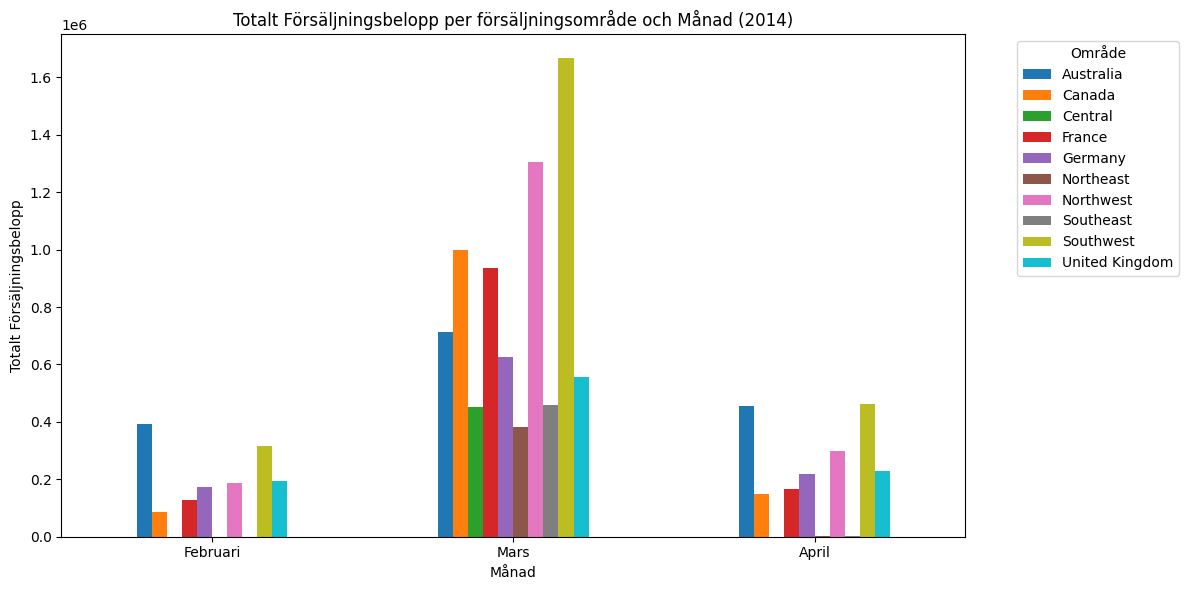

In [ ]:
# Jämförelse ordrar och försäljning per geografiskt försäljningsområde
try:
    with engine.connect() as conn:
        query = """
            SELECT
                YEAR(soh.OrderDate) AS SalesYear,
                MONTH(soh.OrderDate) AS SalesMonth,
                st.Name AS SalesTerritory,
                COUNT(soh.SalesOrderID) AS NumberOfOrders,
                SUM(soh.TotalDue) AS TotalSalesAmount
            FROM 
                Sales.SalesOrderHeader soh
            JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
            WHERE 
                YEAR(soh.OrderDate) = 2014 AND MONTH(soh.OrderDate) IN (2, 3, 4)
            GROUP BY
                YEAR(soh.OrderDate), MONTH(soh.OrderDate), st.Name  -- Upprepa uttrycken här
            ORDER BY 
                SalesMonth, SalesTerritory;
        """

        terr_df = pd.read_sql(text(query), conn)

        month_order = ['Februari', 'Mars', 'April']
        months = {2: 'Februari', 3: 'Mars', 4: 'April'}    # mappa månader
        terr_df['SalesMonthName'] = terr_df['SalesMonth'].map(months)    # skapar ny kolumn
        terr_df['SalesMonthName'] = pd.Categorical(terr_df['SalesMonthName'], categories=month_order, ordered=True)    # konverterar till categorical

        pivot_df = terr_df.pivot(index='SalesMonthName', columns='SalesTerritory', values='NumberOfOrders').fillna(0)
        ax = pivot_df.plot(kind='bar', figsize=(12, 6))
        ax.set_xlabel('Månad')
        ax.set_ylabel('Antal Ordrar')
        ax.set_title('Antal Ordrar per försäljningsområde och Månad (2014)')
        plt.xticks(rotation=0)
        plt.legend(title='Område', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        pivot_df_amount = terr_df.pivot(index='SalesMonthName', columns='SalesTerritory', values='TotalSalesAmount').fillna(0) 
        ax_amount = pivot_df_amount.plot(kind='bar', figsize=(12, 6))
        ax_amount.set_xlabel('Månad')
        ax_amount.set_ylabel('Totalt Försäljningsbelopp')
        ax_amount.set_title('Totalt Försäljningsbelopp per försäljningsområde och Månad (2014)')
        plt.xticks(rotation=0)
        plt.legend(title='Område', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
except sqlalchemy.exc.SQLAlchemyError as e:
    print(f"Ett databasfel inträffade: {e}")
except Exception as e:
    print(f"Ett annat fel inträffade: {e}")
finally:
    engine.dispose()

Cykling är säsongsbetonat men 2013 såg vi inte samma variation i omsättning på våren och även om väder kan påverka så är bedömningen att det är för stor skillnad som syns i omsättningen. Även idrottshändelser kan påverka försäljningen men samtliga stora cykellopp 2014 (Tour de France, Giro d'Italia, m.fl.) kördes senare under året mellan maj-september.

Misstanke finns att variationen är bokföringsteknisk. Orderdatum borde vara korrekt, framförallt vid onlineförsäljningar, men det kan inte uteslutas att manuell registrering gjorts på mars som skulle funnits i februari och/eller i april.      
Rekommendationen är därför att dels titta vidare på bokföringen men också via intervjuer försöka ta reda på om någonting annat vid tidpunkten kan ha påverkat variationen.   

   
Vi tittar här nedan också lite närmare på produkter som är olönsamma.   
Vi ser snabbt att flera produkter är reklam- eller goodwillprodukter där AWC säkerligen medvetet lagt ett mycket attraktivt pris för att sälja i stora volymer och därmed få ökad exponering via klädesplaggen som cyklisterna har på sig.   
Förlusterna är inte värdemässigt så stora för dessa produkter ( i reklamsammanhang) och mest troligt är det en bättre investering än att köpa reklamplats på annat sätt.
Dessa produkterna säljer i stora volymer så vi förutsätter att det är bra kvalitet dessutom trots att de är billiga annars skulle försäljningen snabbt minska.
För att undersöka den saken kikade jag efter reviews men det finns inga som kan styrka detta.   
   
Rekommendationen är att det bör undersökas om möjligen finns att höja priset litegrann, kanske i samband med en omdesign, men det är en hårfin gräns som också kan få kunderna att sluta köpa produkterna.

In [22]:
# Produkter med sämst vinstmarginal
query = """
    SELECT TOP 10
        p.Name AS Produktnamn,
        SUM(sod.OrderQty * sod.UnitPrice) AS 'Total omsättning',
        SUM(sod.OrderQty * p.StandardCost) AS 'Total inköpskostnad', 
        SUM(sod.OrderQty * sod.UnitPrice) - SUM(sod.OrderQty * p.StandardCost) AS 'Total vinst',
        ((SUM(sod.OrderQty * sod.UnitPrice) - SUM(sod.OrderQty * p.StandardCost)) * 100.0 / SUM(sod.OrderQty * sod.UnitPrice)) AS 'Vinstmarginal %'
    FROM
        Sales.SalesOrderDetail sod
    JOIN
        Production.Product p ON sod.ProductID = p.ProductID
    GROUP BY
        p.Name
    ORDER BY
            'Vinstmarginal %' ASC;
"""
worstmargin = pd.read_sql(query, engine)
display(worstmargin.style.format({col: "{:.0f}".format for col in worstmargin.select_dtypes(include=np.number)})) 

,Produktnamn,Total omsättning,Total inköpskostnad,Total vinst,Vinstmarginal %
0,"Long-Sleeve Logo Jersey, L",200241,253741,-53501,-27
1,"Short-Sleeve Classic Jersey, XL",130878,160635,-29757,-23
2,"Long-Sleeve Logo Jersey, M",115509,139958,-24449,-21
3,"Long-Sleeve Logo Jersey, XL",95689,114707,-19018,-20
4,"Short-Sleeve Classic Jersey, L",99143,118398,-19255,-19
5,"Road-650 Red, 44",967980,1097037,-129056,-13
6,"Short-Sleeve Classic Jersey, S",71785,81274,-9489,-13
7,AWC Logo Cap,51512,57531,-6019,-12
8,"LL Road Frame - Black, 58",177636,192348,-14712,-8
9,"LL Road Frame - Black, 52",299764,323512,-23749,-8


In [23]:
# Reviews och rating
query = """
    SELECT
        pr.ProductID,
        p.Name AS Produktnamn,
        AVG(pr.Rating) AS Medelbetyg,
        COUNT(*) AS 'Antal betyg'
    FROM
        Production.ProductReview pr
    JOIN
        Production.Product p ON pr.ProductID = p.ProductID
    GROUP BY
        pr.ProductID, p.Name
    ORDER BY
        Medelbetyg DESC; 
"""
reviews_df = pd.read_sql(query, engine)
reviews_df

,ProductID,Produktnamn,Medelbetyg,Antal betyg
0,709,"Mountain Bike Socks, M",5,1
1,798,"Road-550-W Yellow, 40",5,1
2,937,HL Mountain Pedal,3,2


Det som AWC förlorar störst summor på är ett antal cykelmodeller.   
Det vi kan se är att modellen Road-650 förekommer 6 gånger på listan med de 10 produkterna med sämst förtjänst och vi ser att det till viss del gäller cyklar med antingen lite större ramstorlek för människor över 190 cm eller mindre sådana som passar människor under 160 cm. Det kan vara så att dessa till slut tvingas säljas med förlust för att de inte blivit sålda när nya modeller behöver fasas in.   
   
Rekommendationen är därför att undersöka vidare med försäljningsavdelningen om detta kan stämma och om möjligt skala bort ett antal storlekar för att enbart erbjudas som beställningsvara utan lagerhållning.

In [24]:
# Produkter som säljs med störst förlust mätt i pengar
query = """
    SELECT TOP 10
        p.Name AS Produktnamn,
        SUM(sod.OrderQty * sod.UnitPrice) AS 'Total omsättning',
        SUM(sod.OrderQty * p.StandardCost) AS Inköpskostnad,
        (SUM(sod.OrderQty * sod.UnitPrice) - SUM(sod.OrderQty * p.StandardCost)) AS 'Total Förlust',
        ((SUM(sod.OrderQty * sod.UnitPrice) - SUM(sod.OrderQty * p.StandardCost)) / SUM(sod.OrderQty * sod.UnitPrice)) * 100 AS Vinstmarginal
    FROM
        Sales.SalesOrderDetail sod
    JOIN
        Production.Product p ON sod.ProductID = p.ProductID
    GROUP BY
        p.Name
    HAVING
        ((SUM(sod.OrderQty * sod.UnitPrice) - SUM(sod.OrderQty * p.StandardCost)) / SUM(sod.OrderQty * sod.UnitPrice)) < 0  
    ORDER BY
        'Total Förlust' ASC;
"""
minstprofit_df = pd.read_sql(query, engine)
display(minstprofit_df.style.format({col: "{:.0f}".format for col in minstprofit_df.select_dtypes(include=np.number)}))

,Produktnamn,Total omsättning,Inköpskostnad,Total Förlust,Vinstmarginal
0,"Road-650 Red, 44",967980,1097037,-129056,-13
1,"Touring-1000 Yellow, 60",1578660,1650879,-72219,-5
2,"Road-650 Red, 60",1021148,1086329,-65181,-6
3,"Road-650 Black, 52",1047820,1104824,-57004,-5
4,"Long-Sleeve Logo Jersey, L",200241,253741,-53501,-27
5,"Road-650 Red, 62",881656,922796,-41140,-5
6,"Road-650 Black, 58",871093,910628,-39535,-5
7,"Road-650 Red, 48",880699,918902,-38203,-4
8,"Road-250 Black, 44",2518300,2553224,-34925,-1
9,"ML Road Frame-W - Yellow, 44",486027,517953,-31925,-7


## Executive Summary
Adventure Works Cycles har en uppåtgående trend i omsättning och vinst, men en betydande variation i omsättningen observeras mellan februari och april 2014, vilket kräver ytterligare undersökning av bokföring och eventuella externa faktorer. Onlineförsäljningen ökade extra mycket under 2013 och bidrog till ökad omsättning.   
AWC:s bästsäljande produkter är AWC Logo-kepsen och vattenflaskor, medan ramar till specifika cykelmodeller säljer sämst.   
Produkter med högst vinstmarginal är relaterade till däck och tillbehör, medan logotyptröjor och vissa cykelmodeller har lägst marginal.   
   
Analys av ordervärden visar en snedfördelning med fåtaliga höga ordervärden som påverkar medelvärdet, medan medianen ger en mer representativ bild av typiska ordervärden.   
   
Rekommendationer finns att undersöka variationen i 2014 års försäljning, eventuellt justera prissättningen på reklamprodukter och optimera lagerhållningen av mindre populära cykelstorlekar. 

## Självvärdering   
   
### 1. Utmaningar du haft under arbetet samt hur du hanterat dem.   
Strategi - När jag började kika i tabeller och databasens innehåll fastnade jag ganska snabbt långt ned i strukturerna vilket gjorde att jag förlorade tid. Mycket av det jag kikade på och testade gav ingenting eller blev för avancerat att sy ihop för mig. Det var först efter att jag tagit ett steg bakåt och riktit in mig på ett par spår som jag kände att jag blev mer produktiv.   
   
Kunskaper - Helt klart så har mina envisa försök till att sy ihop tabeller och få ut den data som jag så gärna vill ha inneburit att jag fått lära mig mycket mer pythonkod än vad jag annars skulle gjort under mycket lång tid. Kämpigt men oerhört lärorikt och bästa sättet att få det att fastna. Alla fel och felaktig data har ju behövt reflekteras över, förstå innebörden av samt lösas eller förkastas. Anamma nya sätt att strukturera koden på, göra tillägg för felsökningar och standarder som varit nytt för mig.   
Just hanteringen av felmeddelanden och alla återvändsgränder jag varit inne i har varit det som utvecklat mig mest i arbetet med databasen, den här formen av lärande är superviktig.   
   
Utanför det "tekniska" så har det också varit en utmaning med att ha hela familjen hemma (skollov, semester) under tiden man ska koncentrera sig och skärma av för att arbeta. Inte alltid lätt men nyttig erfarenhet det också.

### 2. Vilket betyg du anser att du skall ha och varför.   
Jag tänker att G är uppnått och kanske nosar jag även på ett VG men är ödmjuk med att här finns fruktansvärt mycket kvar att lära vad gäller både SQL, programmering och visualisering/presentation.

### 3. Tips du hade gett till dig själv i början av kursen nu när du slutfört den.
Att kanske inte lägga så mycket tid på djupet i inledningen utan mer scanna av, ta ett steg bakåt och få en överblick över hela databasen eller projektet för att hitta intressanta delar och problem att analysera och först därefter gå på djupet inom enbart de områden jag bestämt. Det är lätt att fastna längre ner i strukturerna eller med för många smådelar redan i början och tappa tid. Bättre att lägga den tiden på det visuella i slutet istället.


   
      
### Muntlig presentation gjord 2025-01-03